## Problem Description

Like many U.S. cities, Chicago is working to provide as many COVID-19 vaccines as possible to its residents. As of 3/24/2021,
only 24% of city residents have received at least one dose of a COVID-19 vaccine (1), and 12% of residents have received a complete
set of doses of a vaccine. As eligibility requirements are relaxed, and as supply struggles to meet demand, city health officials
will be interested in finding ways to make vaccinations as easy and as widely available as possible, especially those that it
has identified as being uniquely vulnerable to infection, such as poor and minority communities (2). Besides state-run sites,
venues such as grocery stores, pharmacies, and medical centers will serve as local distribution sites that will administer doses
to city residents. This project will seek to compare neighborhoods across Chicago based on the number of grocery stores,
pharmacies, and medical centers and identify any similarities or differences between neighborhoods. Based on this comparison,
this project will remark on any areas of the city that have relatively few venues where vaccines are likely to be obtained.

## Data Description

The data that will be used in the project will be the following:
   
1 - Names and Lat/Long coordinates of Chicago neighborhoods. These will be obtained from the Chicago Data Portal and the
    ArcGIS Geocoder Python package.
    
2 - Location data for grocery stores, pharmacies, and medical centers in Chicago. These will be obtained from HERE           using its Geocoding & Search API (https://developer.here.com/documentation/geocoding-search-api/dev_guide/index.html).
        
With these data, we can use k-means clustering to identify areas of the city that have similar proportions of vaccine sites.

References

1 - "COVID-19 Daily Vaccinations - Chicago Residents - Cumulative Doses by Day" Chicago Data Portal, https://data.cityofchicago.org/Health-Human-Services/COVID-19-Daily-Vaccinations-Chicago-Residents-Cumu/rna5-2pgy
    Accessed 3/25/2021
    
2 - "Chicago COVID-19 Community Vulnerability Index Chicago CCVI" https://www.chicago.gov/content/dam/city/sites/covid/reports/012521/Community_Vulnerability_Index_012521.pdf

Import all needed libraries

In [86]:
import pandas as pd
import numpy as np
import requests
import geocoder
import json
from requests.structures import CaseInsensitiveDict
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

We will scrape Wikipedia for the names of all community areas in Chicago and put them into a Pandas dataframe.

In [87]:
url = 'https://en.wikipedia.org/wiki/Community_areas_in_Chicago#cite_note-City_basics-9'

table = pd.read_html(url)

df = table[0]
df.head()

,Number[8],Name[8],2017[9],Area (sq mi.)[10],Area (km2),2017density (/sq mi.),2017density (/km2)
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50
4,05,North Center,35789,2.05,5.31,17458.05,6740.59


In [88]:
comm_areas = []
data = df['Name[8]']
comm_areas = data.to_frame()

In [89]:
comm_areas.head()

,Name[8]
0,Rogers Park
1,West Ridge
2,Uptown
3,Lincoln Square
4,North Center


In [90]:
comm_areas = comm_areas.rename(columns={'Name[8]':'Community Name'})
comm_areas = comm_areas.drop([77])
comm_areas['Community Name']=comm_areas.replace({'(The) Loop[11]':'The Loop'})
comm_areas

,Community Name
0,Rogers Park
1,West Ridge
2,Uptown
3,Lincoln Square
4,North Center
...,...
72,Washington Heights
73,Mount Greenwood
74,Morgan Park
75,O'Hare


Next, we will use the Geocoder to find the coordinates of each neighborhood.

In [91]:
# initialize your variable to None
lat_lng_coords = None
latitude = []
longitude = []

# loop until you get the coordinates
for comm in comm_areas['Community Name']:
    g = geocoder.arcgis('{}, Chicago, Illinois'.format(comm))
    print(comm,g.latlng)
    while(g.latlng is None):
        g = geocoder.arcgis('{}, Chicago, Illinois'.format(comm))
        print(comm,g.latlng)
    lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

Rogers Park [42.00897000000003, -87.66618999999997]
West Ridge [41.99948000000006, -87.69265999999999]
Uptown [41.96538000000004, -87.66935999999998]
Lincoln Square [41.97583000000003, -87.68913999999995]
North Center [41.95411000000007, -87.68141999999995]
Lake View [41.939820000000054, -87.65681999999998]
Lincoln Park [41.92184000000003, -87.64743999999996]
Near North Side [41.90021000000007, -87.63432999999998]
Edison Park [42.00789000000003, -87.81398999999999]
Norwood Park [41.98572000000007, -87.80663999999996]
Jefferson Park [41.97054000000003, -87.76328999999998]
Forest Glen [41.97640000000007, -87.75360999999998]
North Park [41.98294000000004, -87.71914999999996]
Albany Park [41.968290000000025, -87.72337999999996]
Portage Park [41.95777000000004, -87.76503999999994]
Irving Park [41.953550000000064, -87.73567999999995]
Dunning [41.95274000000006, -87.79650999999996]
Montclare [41.92902000000004, -87.79846999999995]
Belmont Cragin [41.92802000000006, -87.75383999999997]
Hermosa

In [92]:
latlng_data=[latitude,longitude]
column_names= ['Latitude','Longitude']
df2=pd.DataFrame(data=latlng_data).T
df2.columns=column_names
df2.head()

,Latitude,Longitude
0,42.00897,-87.66619
1,41.99948,-87.69266
2,41.96538,-87.66936
3,41.97583,-87.68914
4,41.95411,-87.68142


A correction was needed for the coordinates of the North Lawndale and South Lawndale neighborhoods since the geocoder assumed that the neighborhood names were actually street names. We used Google to find the coordinates of each neighborhood and replaced the values in the dataframe.

In [93]:
df2['Latitude'] = df2['Latitude'].replace([41.90903105113009],41.8581513)
df2['Longitude'] = df2['Longitude'].replace([-87.71922442315874],-87.7138811860826)
df2.head()

,Latitude,Longitude
0,42.00897,-87.66619
1,41.99948,-87.69266
2,41.96538,-87.66936
3,41.97583,-87.68914
4,41.95411,-87.68142


We concantenate our dataframes

In [94]:
comm_areas = pd.concat([comm_areas,df2],axis=1)
comm_areas.head()

,Community Name,Latitude,Longitude
0,Rogers Park,42.00897,-87.66619
1,West Ridge,41.99948,-87.69266
2,Uptown,41.96538,-87.66936
3,Lincoln Square,41.97583,-87.68914
4,North Center,41.95411,-87.68142


We will plot our neighborhoods on a map of Chicago using Folium

In [95]:
address = 'Chicago, Illinois'

geolocator = Nominatim(user_agent="chi_explorer")
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude

In [96]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, community in zip(comm_areas['Latitude'], comm_areas['Longitude'], comm_areas['Community Name']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  

map_chicago

HERE Geocoding & Search API

We will assign the API key and venue types per the documentation. We will filter our request to venues that include grocery stores, pharmacies, and healthcare services.

In [97]:
API_KEY = 'HkE8ie2TZW5Sjve-yNSw-hqLl7ggknqIFpa9D-OhN9I'
LIMIT = 100
types = '600-6300-0066,600-6400-0000,800-8000-0155,800-8000-0158,800-8000-0159'

We define a function to retrieve all venues near each neighborhood and put them into a dataframe.

In [98]:
def getNearbyVenues(names, latitudes, longitudes, types, radius=750):
    
    venues_list=[]
    for name, lat, lng, typ in zip(names, latitudes, longitudes,types):
        print(name)
            
        # create the API request URL
        url = 'https://browse.search.hereapi.com/v1/browse?at={},{}&in=circle:{},{};r={}&limit={}&categories={}&apiKey={}'.format(
            lat,
            lng,
            lat,
            lng,
            radius,
            LIMIT,
            types,
            API_KEY)
            
        # make the GET request
        results = requests.get(url).json()['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['title'], 
            v['position']['lat'], 
            v['position']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We call the function we created to run through all of our neighborhoods.

In [99]:
chicago_venues1 = getNearbyVenues(names=comm_areas['Community Name'],latitudes=comm_areas['Latitude'],longitudes=comm_areas['Longitude'],types=types)

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
The Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing


In [100]:
comm_areas2 = comm_areas.iloc[69:77]
comm_areas2

,Community Name,Latitude,Longitude
69,Ashburn,41.74785,-87.70995
70,Auburn Gresham,41.74319,-87.65504
71,Beverly Hills,41.71201,-87.67090
72,Washington Heights,41.71584,-87.64884
73,Mount Greenwood,41.69145,-87.70830
74,Morgan Park,41.69039,-87.66599
75,O'Hare,41.97959,-87.90446
76,Edgewater,41.98571,-87.66346


In [101]:
chicago_venues2 = getNearbyVenues(names=comm_areas2['Community Name'],latitudes=comm_areas2['Latitude'],longitudes=comm_areas2['Longitude'],types=types)

Ashburn
Auburn Gresham
Beverly Hills
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater


In [102]:
print(chicago_venues2.shape)
chicago_venues2.head()

(118, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ashburn,41.74785,-87.70995,Farm Doula,41.74758,-87.71099,Medical Services/Clinics
1,Ashburn,41.74785,-87.70995,Smith Rudyard MD & Associates SC,41.74988,-87.71022,Family/General Practice Physicians
2,Ashburn,41.74785,-87.70995,79th St Market,41.74982,-87.71714,Grocery
3,Ashburn,41.74785,-87.70995,Star Home Health,41.74520,-87.70264,Healthcare and Healthcare Support Services
4,Ashburn,41.74785,-87.70995,Nader Wholesale Grocer,41.74167,-87.71323,Consumer Services


In [22]:
chicago_venues = chicago_venues1.append(chicago_venues2)
print(chicago_venues.shape)
chicago_venues.head()

(2171, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.00897,-87.66619,Lunt Food Mart,42.00890,-87.66633,Grocery
1,Rogers Park,42.00897,-87.66619,Morse Fresh Market,42.00822,-87.66725,Grocery
2,Rogers Park,42.00897,-87.66619,Rogers Park Center for Massage Therapy,42.00772,-87.66616,Medical Services/Clinics
3,Rogers Park,42.00897,-87.66619,A Wellness Organization,42.00746,-87.66627,Social Services
4,Rogers Park,42.00897,-87.66619,Genoa A Qol Healthcare Company,42.01057,-87.66650,Hospital or Health Care Facility


Using one-hot encoding, we create a new dataframe where the venue types are now columns with values of either 0 (the venue is not in the neighborhood) or 1 (the venue is in the neighborhood).

In [128]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = chicago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Neighborhood,Bakery & Baked Goods Store,Business Services,Casual Dining,Catering & Other Food Services,Chiropractor,Commercial Services,Consumer Goods,Consumer Services,Convenience Store,...,Specialty Clothing Store,Specialty Food Store,Specialty Store,Sweet Shop,Take Out & Delivery Only,Therapist,Veterinary Medicine,Warehouse/Wholesale Store,Wellness Center & Services,Wine & Liquor
0,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We group the rows by neighborhood and take the average number of each venue.

In [191]:
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
chicago_grouped

,Neighborhood,Bakery & Baked Goods Store,Business Services,Casual Dining,Catering & Other Food Services,Chiropractor,Commercial Services,Consumer Goods,Consumer Services,Convenience Store,...,Specialty Clothing Store,Specialty Food Store,Specialty Store,Sweet Shop,Take Out & Delivery Only,Therapist,Veterinary Medicine,Warehouse/Wholesale Store,Wellness Center & Services,Wine & Liquor
0,Albany Park,0.028571,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.028571,0.028571
1,Archer Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.066667,0.000000,0.000000
2,Armour Square,0.000000,0.000000,0.000000,0.000000,0.125000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,Ashburn,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,Auburn Gresham,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,West Lawn,0.000000,0.000000,0.000000,0.000000,0.045455,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.045455,0.000000
72,West Pullman,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
73,West Ridge,0.000000,0.000000,0.033333,0.000000,0.000000,0.0,0.000000,0.000000,0.016667,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.016667
74,West Town,0.000000,0.000000,0.028571,0.028571,0.000000,0.0,0.028571,0.028571,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.028571,0.0,0.000000,0.114286,0.000000


We should note that one neighborhood, O'Hare, is not included in this dataframe. However, that is acceptable since that neighborhood is essentially the O'Hare International Airport, and we wouldn't expect people to use it as a vaccination site.

We take only the venues that we defined earlier as potential vaccination sites and put them into a new dataframe.

In [192]:
chicago_vacc_sites = chicago_grouped[['Neighborhood','Drugstore','Drugstore or Pharmacy','Family/General Practice Physicians','Grocery','Healthcare and Healthcare Support Services','Hospital','Hospital or Health Care Facility','Market','Medical Services/Clinics','Pharmacy','Wellness Center & Services']]
chicago_vacc_sites.head()

,Neighborhood,Drugstore,Drugstore or Pharmacy,Family/General Practice Physicians,Grocery,Healthcare and Healthcare Support Services,Hospital,Hospital or Health Care Facility,Market,Medical Services/Clinics,Pharmacy,Wellness Center & Services
0,Albany Park,0.0,0.085714,0.142857,0.571429,0.000000,0.0,0.00,0.0,0.057143,0.028571,0.028571
1,Archer Heights,0.0,0.000000,0.066667,0.466667,0.066667,0.0,0.00,0.0,0.066667,0.133333,0.000000
2,Armour Square,0.0,0.000000,0.375000,0.000000,0.000000,0.0,0.25,0.0,0.125000,0.000000,0.000000
3,Ashburn,0.0,0.000000,0.200000,0.200000,0.200000,0.0,0.00,0.0,0.200000,0.000000,0.000000
4,Auburn Gresham,0.0,0.000000,0.125000,0.625000,0.000000,0.0,0.25,0.0,0.000000,0.000000,0.000000


Let's explore the dataframe a bit more.

In [193]:
chicago_vacc_sites.describe()

,Drugstore,Drugstore or Pharmacy,Family/General Practice Physicians,Grocery,Healthcare and Healthcare Support Services,Hospital,Hospital or Health Care Facility,Market,Medical Services/Clinics,Pharmacy,Wellness Center & Services
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.000600,0.021313,0.247321,0.283587,0.028198,0.001322,0.042186,0.005211,0.156304,0.045506,0.010626
std,0.002625,0.036877,0.190637,0.221132,0.070343,0.006173,0.068636,0.029432,0.128510,0.069968,0.021730
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.090909,0.081731,0.000000,0.000000,0.000000,0.000000,0.064286,0.000000,0.000000
50%,0.000000,0.000000,0.228288,0.265993,0.000000,0.000000,0.018333,0.000000,0.136364,0.023611,0.000000
75%,0.000000,0.038846,0.375000,0.454545,0.020814,0.000000,0.051389,0.000000,0.222846,0.049385,0.011598
max,0.015625,0.181818,0.753425,1.000000,0.500000,0.045455,0.250000,0.250000,0.500000,0.400000,0.114286


A boxplot will show the spread of our data in each column. We can easily spot any outliers.

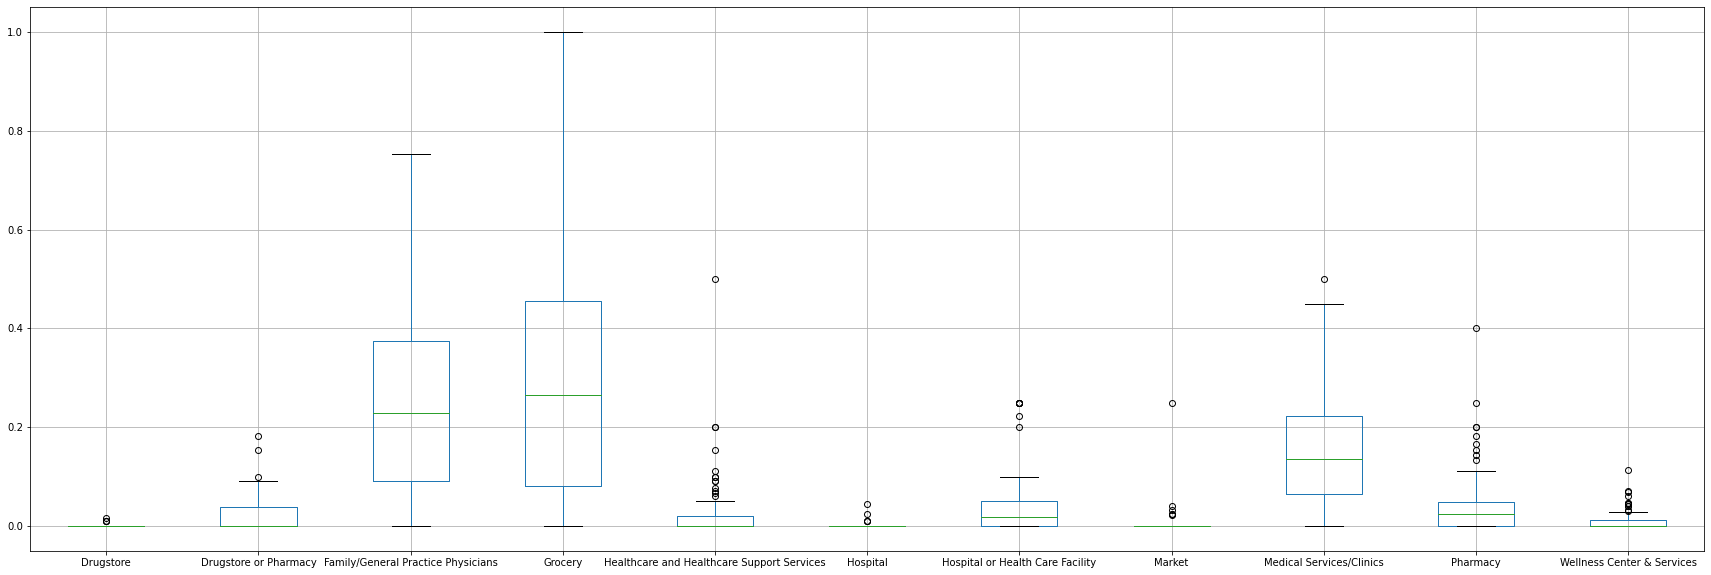

In [194]:
boxplot = chicago_vacc_sites.boxplot(figsize=(30,10))

The values for Family/General Practie Physicians, Grocery Stores, and Medical Servies/Clinics have a much greater distribution than the other venue types. We will drop these columns so as not to skew our analysis.

In [195]:
chicago_vacc_sites = chicago_vacc_sites[['Neighborhood','Drugstore','Drugstore or Pharmacy','Healthcare and Healthcare Support Services','Hospital','Hospital or Health Care Facility', 'Market','Pharmacy','Wellness Center & Services']]
chicago_vacc_sites.head()

,Neighborhood,Drugstore,Drugstore or Pharmacy,Healthcare and Healthcare Support Services,Hospital,Hospital or Health Care Facility,Market,Pharmacy,Wellness Center & Services
0,Albany Park,0.0,0.085714,0.000000,0.0,0.00,0.0,0.028571,0.028571
1,Archer Heights,0.0,0.000000,0.066667,0.0,0.00,0.0,0.133333,0.000000
2,Armour Square,0.0,0.000000,0.000000,0.0,0.25,0.0,0.000000,0.000000
3,Ashburn,0.0,0.000000,0.200000,0.0,0.00,0.0,0.000000,0.000000
4,Auburn Gresham,0.0,0.000000,0.000000,0.0,0.25,0.0,0.000000,0.000000


Let's combine similar columns for easier analysis and interpretation. We will take the sums of all pharmacies and drugstores and put them in a single column.

In [196]:
sum_pharmacy = chicago_vacc_sites['Drugstore'] + chicago_vacc_sites['Drugstore or Pharmacy'] + chicago_vacc_sites['Pharmacy']
chicago_vacc_sites['Total Avg. Pharmacies'] = sum_pharmacy
chicago_vacc_sites

,Neighborhood,Drugstore,Drugstore or Pharmacy,Healthcare and Healthcare Support Services,Hospital,Hospital or Health Care Facility,Market,Pharmacy,Wellness Center & Services,Total Avg. Pharmacies
0,Albany Park,0.0,0.085714,0.000000,0.0,0.000000,0.000000,0.028571,0.028571,0.114286
1,Archer Heights,0.0,0.000000,0.066667,0.0,0.000000,0.000000,0.133333,0.000000,0.133333
2,Armour Square,0.0,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000
3,Ashburn,0.0,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,Auburn Gresham,0.0,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
71,West Lawn,0.0,0.068182,0.000000,0.0,0.000000,0.000000,0.045455,0.045455,0.113636
72,West Pullman,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.400000,0.000000,0.400000
73,West Ridge,0.0,0.066667,0.016667,0.0,0.016667,0.033333,0.033333,0.000000,0.100000
74,West Town,0.0,0.057143,0.028571,0.0,0.057143,0.000000,0.028571,0.114286,0.085714


We will do the same thing for health care centers, hospitals, and other related facilities.

In [198]:
sum_healthcare = chicago_vacc_sites['Healthcare and Healthcare Support Services'] + chicago_vacc_sites['Hospital'] + chicago_vacc_sites['Hospital or Health Care Facility'] + chicago_vacc_sites['Wellness Center & Services']
chicago_vacc_sites['Total Avg. Healthcare Centers'] = sum_healthcare
chicago_vacc_sites

,Neighborhood,Drugstore,Drugstore or Pharmacy,Healthcare and Healthcare Support Services,Hospital,Hospital or Health Care Facility,Market,Pharmacy,Wellness Center & Services,Total Avg. Pharmacies,Total Avg. Healthcare Centers
0,Albany Park,0.0,0.085714,0.000000,0.0,0.000000,0.000000,0.028571,0.028571,0.114286,0.028571
1,Archer Heights,0.0,0.000000,0.066667,0.0,0.000000,0.000000,0.133333,0.000000,0.133333,0.066667
2,Armour Square,0.0,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000
3,Ashburn,0.0,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
4,Auburn Gresham,0.0,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...
71,West Lawn,0.0,0.068182,0.000000,0.0,0.000000,0.000000,0.045455,0.045455,0.113636,0.045455
72,West Pullman,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.400000,0.000000,0.400000,0.000000
73,West Ridge,0.0,0.066667,0.016667,0.0,0.016667,0.033333,0.033333,0.000000,0.100000,0.033333
74,West Town,0.0,0.057143,0.028571,0.0,0.057143,0.000000,0.028571,0.114286,0.085714,0.200000


In [199]:
chicago_vacc_sites_agg = chicago_vacc_sites[['Neighborhood','Market','Total Avg. Pharmacies','Total Avg. Healthcare Centers']]
chicago_vacc_sites_agg.head()

,Neighborhood,Market,Total Avg. Pharmacies,Total Avg. Healthcare Centers
0,Albany Park,0.0,0.114286,0.028571
1,Archer Heights,0.0,0.133333,0.066667
2,Armour Square,0.0,0.000000,0.250000
3,Ashburn,0.0,0.000000,0.200000
4,Auburn Gresham,0.0,0.000000,0.250000


We have our dataframe of neighborhoods and the total average number of pharmacies, clinics, and markets. We can proceed to perform our clustering analysis.

We first will use the Elbow method to determine the optimal number of clusters that we should model. The number will be found at the point where the distortion decreases at a linear rate.

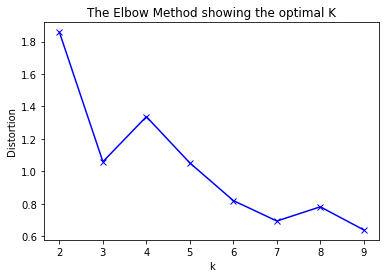

In [200]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

distortions = []
kmax = 10

chicago_vacc_sites_cluster = chicago_vacc_sites_agg.drop('Neighborhood',1)

for k in range(2, kmax):
  kmeans = KMeans(n_clusters = k,random_state = 0).fit(chicago_vacc_sites_cluster)
  distortions.append(sum(np.min(cdist(chicago_vacc_sites_cluster,kmeans.cluster_centers_,'canberra'),axis=1))/chicago_vacc_sites_cluster.shape[0])

plt.plot(range(2,kmax),distortions,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K')
plt.show()

The optimal number of clusters is 4. We use that to create our model and fit our site data.

In [201]:
kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state = 0).fit(chicago_vacc_sites_cluster)

kmeans.labels_[0:10]

array([1, 1, 0, 0, 0, 3, 0, 1, 1, 0])

With our cluster labels, we insert them into our site dataframe.

In [202]:
chicago_vacc_sites_agg.insert(0,'Cluster Labels', kmeans.labels_)

comm_areas = comm_areas.rename(columns={'Community Name':'Neighborhood'})

chicago_vacc_sites_merged = comm_areas

We merge this site dataframe with our lat/lon coordinates dataframe so we can plot on a map using Folium.

In [203]:
chicago_vacc_sites_merged = chicago_vacc_sites_merged.join(chicago_vacc_sites_agg.set_index('Neighborhood'),on='Neighborhood')
chicago_vacc_sites_merged = chicago_vacc_sites_merged.dropna(axis=0)
chicago_vacc_sites_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Market,Total Avg. Pharmacies,Total Avg. Healthcare Centers
0,Rogers Park,42.00897,-87.66619,3.0,0.000000,0.000000,0.028571
1,West Ridge,41.99948,-87.69266,1.0,0.033333,0.100000,0.033333
2,Uptown,41.96538,-87.66936,1.0,0.000000,0.093023,0.093023
3,Lincoln Square,41.97583,-87.68914,3.0,0.000000,0.013699,0.000000
4,North Center,41.95411,-87.68142,3.0,0.000000,0.049180,0.032787


In [204]:
chicago_vacc_sites_merged['Cluster Labels'] = chicago_vacc_sites_merged['Cluster Labels'].astype('int32')

In [205]:
chicago_vacc_sites_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Market,Total Avg. Pharmacies,Total Avg. Healthcare Centers
0,Rogers Park,42.00897,-87.66619,3,0.000000,0.000000,0.028571
1,West Ridge,41.99948,-87.69266,1,0.033333,0.100000,0.033333
2,Uptown,41.96538,-87.66936,1,0.000000,0.093023,0.093023
3,Lincoln Square,41.97583,-87.68914,3,0.000000,0.013699,0.000000
4,North Center,41.95411,-87.68142,3,0.000000,0.049180,0.032787


Now we plot our clusters, assigning a unique color to each one.

In [209]:
map_clusters = folium.Map(location=[latitude1,longitude1], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, community, cluster in zip(chicago_vacc_sites_merged['Latitude'], chicago_vacc_sites_merged['Longitude'], chicago_vacc_sites_merged['Neighborhood'],chicago_vacc_sites_merged['Cluster Labels']):
    label = '{}'.format(community)
    label = folium.Popup(label + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7,).add_to(map_clusters)  

map_clusters



We aggregate our data based on our new cluster labels.

In [207]:
chicago_vacc_sites_merged.groupby('Cluster Labels').mean()

,Latitude,Longitude,Market,Total Avg. Pharmacies,Total Avg. Healthcare Centers
Cluster Labels,,,,,
0,41.787122,-87.654521,0.000000,0.038217,0.244313
1,41.862978,-87.690822,0.003599,0.111416,0.058060
2,41.710295,-87.627460,0.000000,0.381818,0.000000
3,41.844238,-87.665042,0.009115,0.019760,0.043668


Let's use a boxplot to see how our clusters compare to one another.

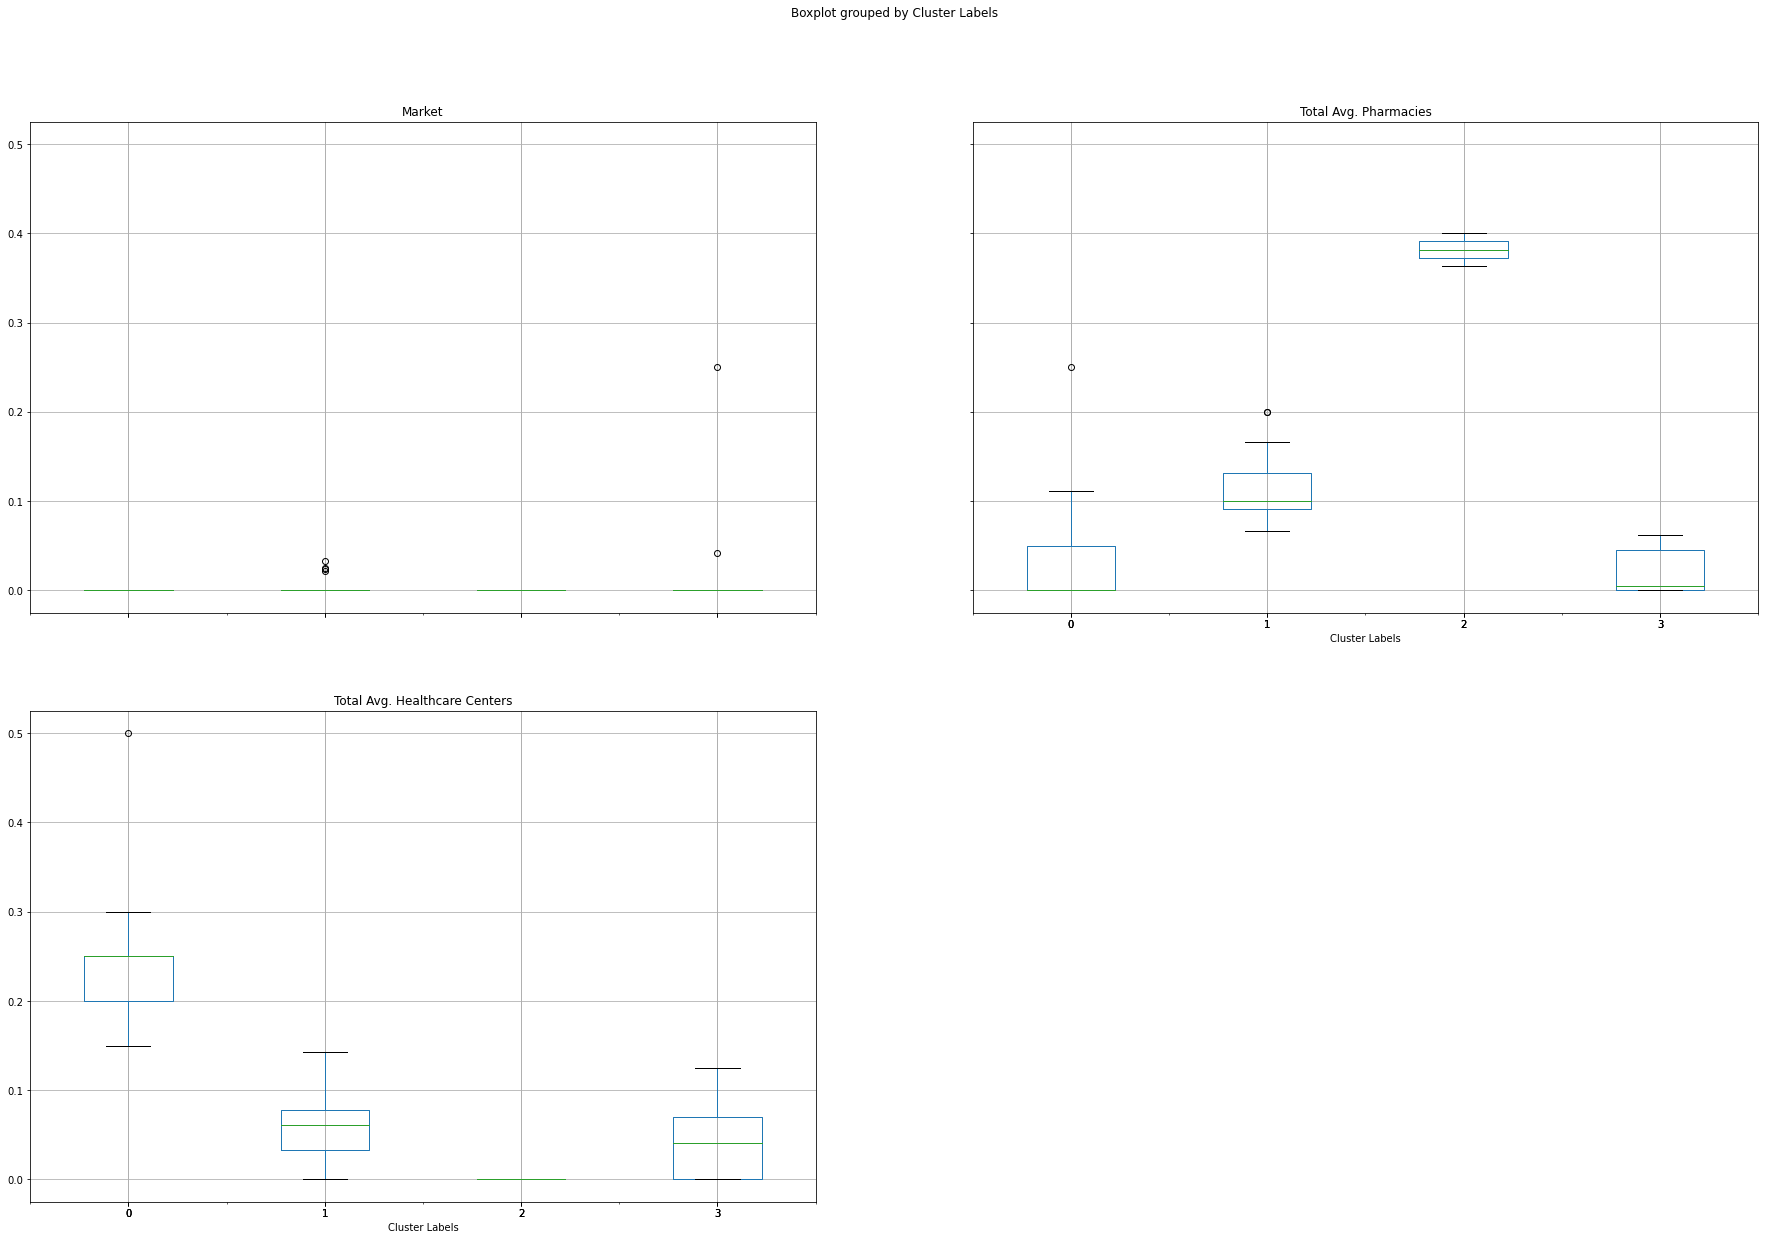

In [208]:
categories = ['Market','Total Avg. Pharmacies','Total Avg. Healthcare Centers']
boxplot = chicago_vacc_sites_merged.boxplot(column=categories,by='Cluster Labels',figsize = (30,20))

Based on the above, we can describe our clusters in the following ways:
    
   Cluster 1 (label 0) has, on average, more health care centers than the others and
   few markets.
    
   Cluster 2 (label 1) has the most number of neighborhoods of all clusters. It has the second
   most number of pharmacies on average, and the second highest average number of markets.
    
   Cluster 3 (label 2) has significantly more pharmacies than the other clusters. It has the
   fewest number of markets and healthcare centers.
    
   Cluster 4 (label 3) has a few neighborhoods with access to markets, but it has, on
   average, very few pharmacies and healthcare centers.

Let's list the number of neighborhoods in each cluster.

In [169]:
chicago_vacc_sites_merged.loc[chicago_vacc_sites_merged['Cluster Labels'] == 0, chicago_vacc_sites_merged.columns[[0] + list(range(4, chicago_vacc_sites_merged.shape[1]))]]

,Neighborhood,Market,Total Avg. Pharmacies,Total Avg. Healthcare Centers
19,Hermosa,0.0,0.000000,0.153846
23,West Town,0.0,0.085714,0.200000
33,Armour Square,0.0,0.000000,0.250000
35,Oakland,0.0,0.000000,0.250000
38,Kenwood,0.0,0.050000,0.150000
44,Avalon Park,0.0,0.000000,0.200000
50,South Deering,0.0,0.000000,0.250000
58,McKinley Park,0.0,0.111111,0.222222
63,Clearing,0.0,0.000000,0.500000
69,Ashburn,0.0,0.000000,0.200000


In [170]:
chicago_vacc_sites_merged.loc[chicago_vacc_sites_merged['Cluster Labels'] == 1, chicago_vacc_sites_merged.columns[[0] + list(range(4, chicago_vacc_sites_merged.shape[1]))]]

,Neighborhood,Market,Total Avg. Pharmacies,Total Avg. Healthcare Centers
1,West Ridge,0.033333,0.100000,0.033333
2,Uptown,0.000000,0.093023,0.093023
8,Edison Park,0.000000,0.071429,0.142857
11,Forest Glen,0.000000,0.153846,0.076923
13,Albany Park,0.000000,0.114286,0.028571
15,Irving Park,0.000000,0.111111,0.111111
17,Montclare,0.000000,0.090909,0.090909
18,Belmont Cragin,0.000000,0.131579,0.078947
20,Avondale,0.000000,0.076923,0.038462
21,Logan Square,0.022222,0.066667,0.066667


In [171]:
chicago_vacc_sites_merged.loc[chicago_vacc_sites_merged['Cluster Labels'] == 2, chicago_vacc_sites_merged.columns[[0] + list(range(4, chicago_vacc_sites_merged.shape[1]))]]

,Neighborhood,Market,Total Avg. Pharmacies,Total Avg. Healthcare Centers
43,Chatham,0.0,0.363636,0.0
52,West Pullman,0.0,0.400000,0.0


In [172]:
chicago_vacc_sites_merged.loc[chicago_vacc_sites_merged['Cluster Labels'] == 3, chicago_vacc_sites_merged.columns[[0] + list(range(4, chicago_vacc_sites_merged.shape[1]))]]

,Neighborhood,Market,Total Avg. Pharmacies,Total Avg. Healthcare Centers
0,Rogers Park,0.000000,0.000000,0.028571
3,Lincoln Square,0.000000,0.013699,0.000000
4,North Center,0.000000,0.049180,0.032787
5,Lake View,0.000000,0.020000,0.030000
6,Lincoln Park,0.000000,0.062500,0.046875
7,Near North Side,0.000000,0.050000,0.110000
9,Norwood Park,0.000000,0.020000,0.060000
10,Jefferson Park,0.000000,0.055556,0.083333
12,North Park,0.000000,0.000000,0.000000
14,Portage Park,0.000000,0.040000,0.080000


### Discussion

We have found four distinct clusters across Chicago based on neighborhood access to pharmacies, markets, and health care centers, which
will be heavily used by residents to receive vaccines for COVID-19 for the coming months. Supermarkets, on the whole, are not the best
sites for wide distribution of vaccines, as they are not as plentiful as drugstores and clinics. Public health officials would
be wise to make pharmacies a primary distribution channel for vaccines, as they are plentiful across many neighborhoods. Two neighborhoods
in particular, Chatham and West Pullman, would rely solely on pharmacies as a means to vaccinate residents. Health care centers,
including hospitals and clinics, can certainly supplement the distribution of vaccines since they cover a measurable portion of 
neighborhoods.

### Conclusion

Machine learning has a wide array of applications, including in the area of public health. By using k-means clustering, an unsupervised
learning technique, we can group neighborhoods across the City of Chicago into clusters and compare them based on the number of
venues that city officials and local media have identified as vaccination sites. We analyzed each cluster and remarked on the
defining characteristics of each one and made recommendations for distribution strategies based on our findings. During our initial
data wrangling, we chose to exclude data that appeared to be highly skewed. Should this analysis be refined, we can find a way to
incorporate and normalize this data so as not to skew the results of our clustering. Public health officials are certainly interested
in finding ways to vaccinate as many residents as possible. Data science can be a powerful tool in order to help them do just that.